In [1]:
import matplotlib.pyplot as plt
import incense
from common.helper.config import parseMongoConfig

loader = incense.ExperimentLoader(**parseMongoConfig('../config.ini', adapt='IncenseExperimentLoader'))

/home/jroeger/data/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load all experiments

In [2]:
all_qat_experiments_query = {
    '$and': [
        {
            'experiment.name': 'QAT_CNN-IMU'
        },
        {
            'status': 'COMPLETED'
        },
    ]
}
all_experiments = loader.find(all_qat_experiments_query)
print(f'Loaded {len(all_experiments)} QAT Experiments')

base_experiment_by_dataset = {}
for ex in all_experiments:
  cfg = ex.to_dict()['config']
  if cfg['use_dataset'] in base_experiment_by_dataset:
    assert base_experiment_by_dataset[cfg['use_dataset']] == cfg['base_experiment_id']
  else:
    base_experiment_by_dataset[cfg['use_dataset']] = cfg['base_experiment_id']
base_experiment_by_dataset = {
  d: loader.find_by_id(e_id)
  for d, e_id in base_experiment_by_dataset.items()
}
print(f'Base Experiments {base_experiment_by_dataset!s}')

Loaded 82 QAT Experiments
Base Experiments {'lara': Experiment(id=225, name=CNN-IMU_LARa), 'pamap2': Experiment(id=204, name=CNN-IMU_Pamap2(activity_labels)), 'opportunity': Experiment(id=173, name=CNN-IMU_Opportunity-Locomotion)}


# Best Experiment by Dataset compared to baseline

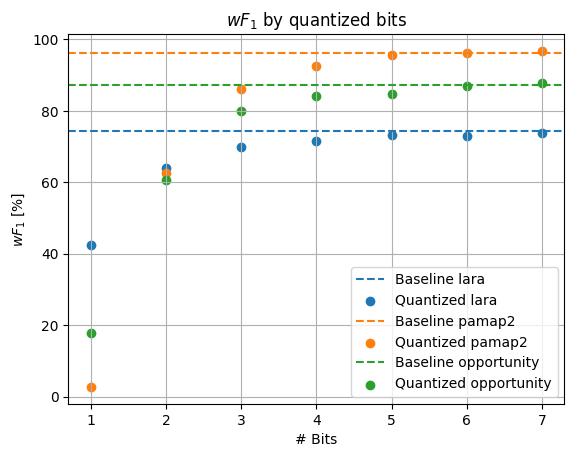

In [3]:
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

experiments_by_bits_by_dataset = defaultdict(lambda: defaultdict(list))
for e in all_experiments:
  cfg = e.to_dict()['config']
  experiments_by_bits_by_dataset[cfg['use_dataset']][cfg['n_bits']].append(e)

best_wf1_by_bits_by_dataset = {
    dataset: {
        bits: max(exs, key=lambda e: e.metrics['test/wf1'].item())
        for bits, exs in exs_by_bit.items()
    } for dataset, exs_by_bit in experiments_by_bits_by_dataset.items()
}

cmap = cm.get_cmap('tab10')

fig, ax = plt.subplots()
for ix, dataset in enumerate(best_wf1_by_bits_by_dataset):
  x_values = list(best_wf1_by_bits_by_dataset[dataset].keys())
  wf1_values = np.array([ex.metrics['test/wf1'].item() for ex in best_wf1_by_bits_by_dataset[dataset].values()])
  baseline_wf1 = base_experiment_by_dataset[dataset].metrics['test/wf1'].max()

  ax.axhline(y=baseline_wf1*100, color=cmap(ix), label=f'Baseline {dataset}', linestyle='dashed')
  ax.scatter(x=x_values, y=wf1_values*100, color=cmap(ix), label=f'Quantized {dataset}')

ax.set_ylabel(f'$wF_1$ [%]')
ax.set_xlabel(f'# Bits')
ax.grid()
ax.legend()
ax.set_title('$wF_1$ by quantized bits')
fig.show()

# Batch-Time statistics by configuration

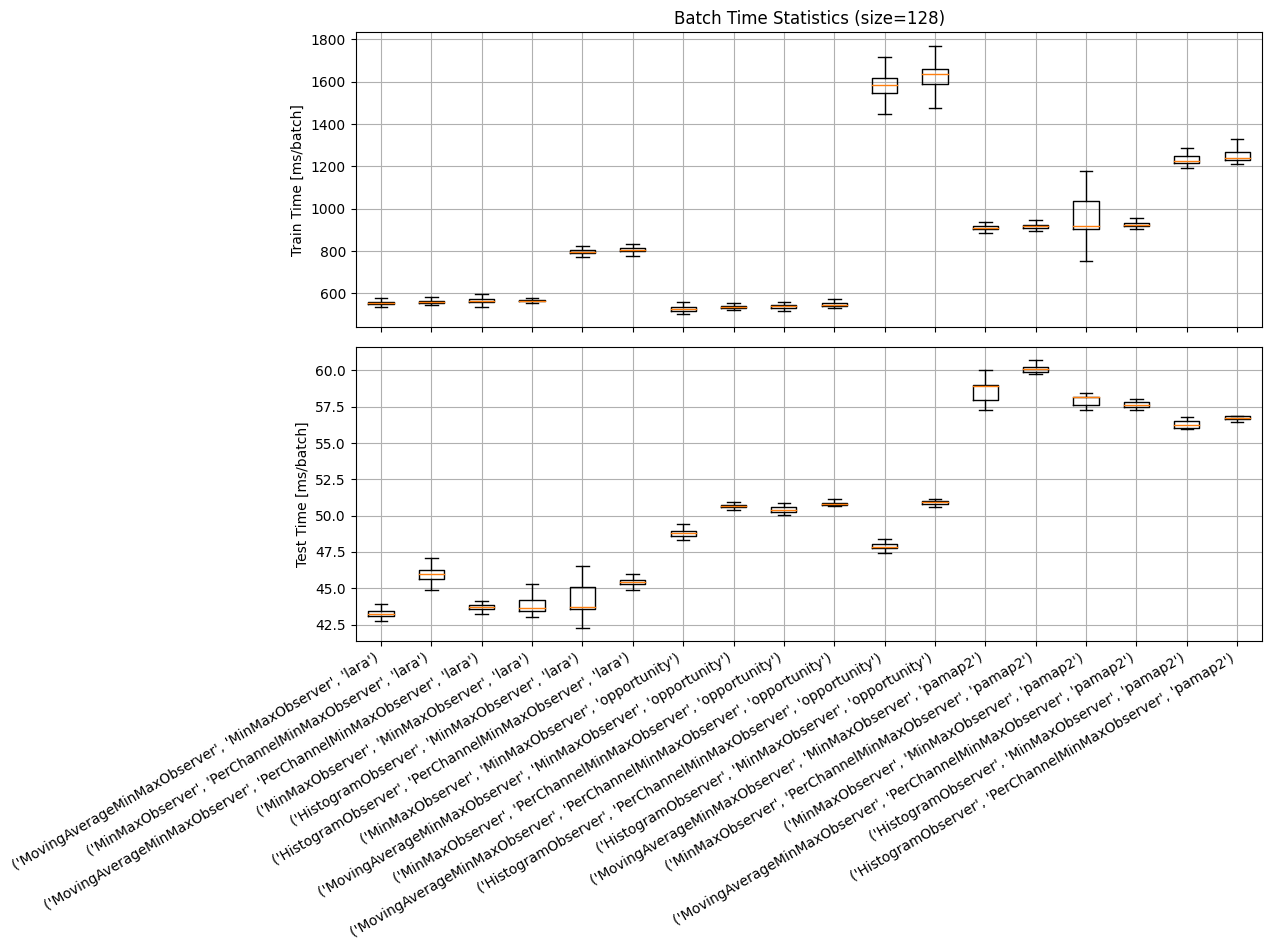

In [4]:
from common.eval.algorithms import groupByConfigKeys

group_cfg_keys = ('activation_observer', 'weight_observer', 'use_dataset')

experiment_by_cfg = groupByConfigKeys(group_cfg_keys, lambda e: e.to_dict()['config'],
                                      all_experiments)
experiment_by_cfg = {
    key: max(exs, key=lambda ex: ex.metrics['test/wf1'].item())
    for key, exs in experiment_by_cfg.items()
}

experiment_by_cfg = {
    k: v for k, v in sorted(experiment_by_cfg.items(),
                            key=lambda t: (t[0][-1], t[1].metrics['train/batch_time'].median()))
}

fig, ax = plt.subplots(2,1)
fig.set_figwidth(fig.get_figwidth()*2)
fig.set_figheight(fig.get_figheight()*2)
boxplot_labels = []
train_boxplot_data = []
test_boxplot_data = []
for cfg_key, ex in experiment_by_cfg.items():
  train_boxplot_data.append(ex.metrics['train/batch_time']*1000)
  boxplot_labels.append(tuple(key.split('.')[-1] for key in cfg_key))
  test_boxplot_data.append(ex.metrics['test/batch_time']*1000)
ax[0].boxplot(x=train_boxplot_data, showfliers=False)
ax[1].boxplot(x=test_boxplot_data, showfliers=False)
ax[1].set_xticklabels(boxplot_labels)
ax[0].set_ylabel('Train Time [ms/batch]')
ax[0].grid()
ax[1].set_ylabel('Test Time [ms/batch]')
ax[1].grid()
ax[0].set_title('Batch Time Statistics (size=128)')
fig.autofmt_xdate()
fig.tight_layout()
fig.show()